# Defining the first processor

Here we will transform the work done in the first notebook to a processor.

In [1]:
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights
import numpy as np

def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)
    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 
    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (ak.sum(matchedH.pt>0,axis=1)==1)*1 + (ak.sum(ak.flatten(matchedW.pt>0,axis=2),axis=1)==1)*3 + (ak.sum(ak.flatten(matchedWstar.pt>0,axis=2),axis=1)==1)*5    
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    return hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs

class HwwSignalProcessor(processor.ProcessorABC):
    def __init__(self,jet_arbitration='pt'):
        self._jet_arbitration = jet_arbitration
        
        # define an output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.IntCategory([0, 2, 4, 6, 8], name='genflavor', label='gen flavor'),
                hist2.axis.IntCategory([0, 1, 4, 6, 9], name='genHflavor', label='higgs matching'),
                hist2.axis.Regular(100, 200, 1200, name='pt', label=r'Jet $p_T$'),
                hist2.axis.Regular(4, 0, 4, name='nprongs', label='Jet n prongs'),
                hist2.storage.Weight(),
            )
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)

        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        # met
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
        
        # match HWWlepqq (assume that we are always running in simulation)
        hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs = match_HWWlepqq(events.GenPart,candidatefj)
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
        
        # here we fill our histogram
        output['signal_kin'].fill(
                    genflavor=normalize(hWWlepqq_flavor),
                    genHflavor=normalize(hWWlepqq_matched),
                    pt = normalize(candidatefj.pt),
                    nprongs = normalize(hWWlepqq_nprongs),
                    weight=weights.weight(),
                )

        return {dataset: output}

    def postprocess(self, accumulator):
        return accumulator

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

fileset = {
    'HWW': [
        'data/nano_mc2017_1-130.root',
    ],
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=HwwSignalProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
    },
    maxchunks=30,
)
out

/Users/cmantill/miniconda3/envs/hww/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()


{'HWW': {'sumw': 1929879.2,
  'signal_kin': Hist(
    IntCategory([0, 2, 4, 6, 8]),
    IntCategory([0, 1, 4, 6, 9]),
    Regular(100, 200, 1200, name='pt', label='Jet $p_T$'),
    Regular(4, 0, 4, name='nprongs', label='Jet n prongs'),
    storage=Weight()) # Sum: WeightedSum(value=28893, variance=834805) (WeightedSum(value=1.92988e+06, variance=5.5765e+07) with flow)}}

No handles with labels found to put in legend.


  category(0, 1, 4, 6, 9, metadata={'name': 'genHflavor', 'label': 'higgs matching'}, options=overflow)
  (0): 2.205e+04 (1): 0         (2): 693.4     (3): 0        
  (4): 6385      (5): 1.901e+06



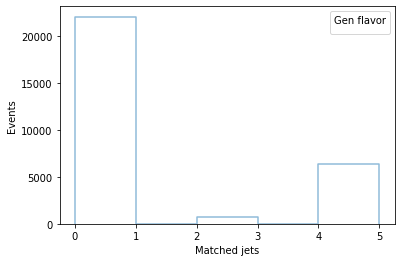

In [3]:
import matplotlib.pyplot as plt

gen_Hflavor = out["HWW"]["signal_kin"][{"genflavor": sum, "pt": sum, "nprongs":sum}]
print(gen_Hflavor)

fig, ax = plt.subplots()
gen_Hflavor.plot1d(
    ax=ax,
    alpha=0.5,
)
# you can edit features of the plot afterwards using matplotlib object-oriented syntax
ax.set_ylabel("Events")
ax.set_xlabel("Matched jets")

# will probably need to add handles with labels to put in the legend..
ax.legend(title="Gen flavor")


Now, you want to:
1. add more histograms/plots and 
2. run for the full dataset using coffea.casa. Instructions are here: https://coffea-casa.readthedocs.io/en/latest/cc_user.html#access and also linked in the coffea hats